# Credit Card Fraud Detection

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import os

# import dataset test and train

In [35]:
train_df = pd.read_csv('/kaggle/input/fraud-detection/fraudTrain.csv')
test_df = pd.read_csv('/kaggle/input/fraud-detection/fraudTest.csv')
print("Train fraud Data size=",train_df.shape)
print("Test fraud Data size=",test_df.shape)

Train fraud Data size= (1296675, 23)
Test fraud Data size= (555719, 23)


In [36]:
print(train_df.describe())  # General statistics

         Unnamed: 0        cc_num           amt           zip           lat  \
count  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06   
mean   6.483370e+05  4.171920e+17  7.035104e+01  4.880067e+04  3.853762e+01   
std    3.743180e+05  1.308806e+18  1.603160e+02  2.689322e+04  5.075808e+00   
min    0.000000e+00  6.041621e+10  1.000000e+00  1.257000e+03  2.002710e+01   
25%    3.241685e+05  1.800429e+14  9.650000e+00  2.623700e+04  3.462050e+01   
50%    6.483370e+05  3.521417e+15  4.752000e+01  4.817400e+04  3.935430e+01   
75%    9.725055e+05  4.642255e+15  8.314000e+01  7.204200e+04  4.194040e+01   
max    1.296674e+06  4.992346e+18  2.894890e+04  9.978300e+04  6.669330e+01   

               long      city_pop     unix_time     merch_lat    merch_long  \
count  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06   
mean  -9.022634e+01  8.882444e+04  1.349244e+09  3.853734e+01 -9.022646e+01   
std    1.375908e+01  3.019564e+05  1.284128e+07  5.

In [37]:
train_df.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

Check data description and null value of train data

In [38]:
test_df.head(5)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [39]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [40]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  int64  
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long                   555719 non-nu

# Data analysis and Visualization

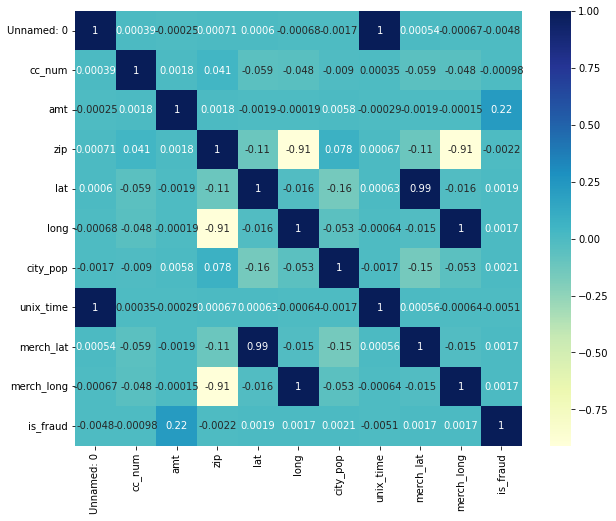

In [41]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(train_df.corr(),cmap="YlGnBu", annot=True)
plt.show()

Note: From heatmap amount has highly correlated with is_fraud

(Heatmap if value close to 1 and color close to white meaning 2 features have highly correlated)

## Most amount scamed and there gender information

In [42]:
train_df.loc[train_df['is_fraud'] == 1].sort_values('amt', ascending=False).head(2)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
1262544,1262544,2020-06-08 22:14:13,3562793934111141,fraud_Kuhn LLC,shopping_pos,1376.04,Meagan,Edwards,F,10376 Bullock Rapid,...,38.9456,-75.9777,777,Television production assistant,1997-04-17,9a7f96694d672499c10b6085fadecd30,1370729653,38.004592,-75.446751,1
514148,514148,2019-08-10 22:10:23,3500969075198072,fraud_Metz-Boehm,shopping_pos,1371.81,Kenneth,Sanchez,M,0110 Ashley Forest,...,47.2271,-117.0819,895,Clothing/textile technologist,1999-05-31,20cf5453224328229e06ae7b4df10302,1344636623,47.065996,-116.262297,1


<AxesSubplot:title={'center':'Number of frauds by category'}, xlabel='gender', ylabel='is_fraud'>

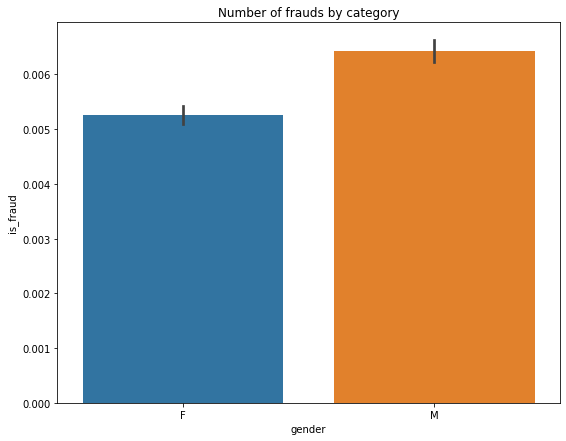

In [43]:
# Age
plt.figure(figsize=(9,7))
plt.title('Number of frauds by category')
sns.barplot(x="gender", y='is_fraud' ,data=train_df)

<AxesSubplot:title={'center':'Number of frauds by category'}, xlabel='category', ylabel='is_fraud'>

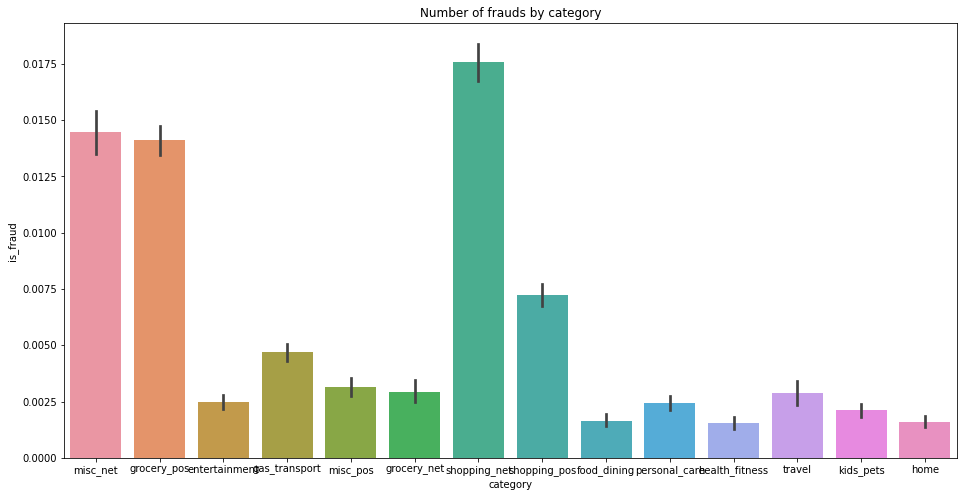

In [44]:
# Category
plt.figure(figsize=(16,8))
plt.title('Number of frauds by category')
sns.barplot(x="category", y='is_fraud' ,data=train_df)

# Pre-Processing
## Downsampling Data
Use downsampling solution because targets are imbalance data

In [45]:
print("Number of is_fraud data")
print(train_df['is_fraud'].value_counts())

Number of is_fraud data
0    1289169
1       7506
Name: is_fraud, dtype: int64


is_fraud = 0 has 1289169 data

is_fraud = 1 has 7506 data

Amount of is_fraud is very different, it can make overfitting

In [46]:
from sklearn.utils import resample 
# .iloc[:,22] = is_fraud
df_minority = train_df[train_df.iloc[:,22].values==0]
df_majority = train_df[train_df.iloc[:,22].values==1] 
 
# Downsample majority class
df_minority_downsampled = resample(df_minority,
                                 n_samples=7506,
                                 random_state=42)
 
# Combine minority class with downsampled majority class
train_df_final = pd.concat([df_minority_downsampled, df_majority])
 
# final train data
train_df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15012 entries, 123118 to 1295733
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             15012 non-null  int64  
 1   trans_date_trans_time  15012 non-null  object 
 2   cc_num                 15012 non-null  int64  
 3   merchant               15012 non-null  object 
 4   category               15012 non-null  object 
 5   amt                    15012 non-null  float64
 6   first                  15012 non-null  object 
 7   last                   15012 non-null  object 
 8   gender                 15012 non-null  object 
 9   street                 15012 non-null  object 
 10  city                   15012 non-null  object 
 11  state                  15012 non-null  object 
 12  zip                    15012 non-null  int64  
 13  lat                    15012 non-null  float64
 14  long                   15012 non-null  float64


In [47]:
print("Number of is_fraud data",train_df_final['is_fraud'].value_counts())

Number of is_fraud data 0    7506
1    7506
Name: is_fraud, dtype: int64


Note: Now is_fraud = 0 and is_fruad = 1 have amount = 7506 both

# Data Tranformation

### Train Data

In [48]:

train_df_final['trans_date_trans_time'] = pd.to_datetime(train_df_final['trans_date_trans_time'])
train_df_final['week_number'] = train_df_final['trans_date_trans_time'].dt.dayofweek
assert train_df_final['week_number'].max() == 6
train_df_final['month_number'] = train_df_final['trans_date_trans_time'].dt.month
assert train_df_final['month_number'].max() == 12
train_df_final['year'] = train_df_final['trans_date_trans_time'].dt.year
train_df_final.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,week_number,month_number,year
123118,123118,2019-03-10 03:24:30,30011465039817,fraud_Huels-Nolan,gas_transport,67.66,Lisa,Garcia,F,213 Gill Expressway,...,Human resources officer,1971-10-14,6744f95a0c456529c4a35cb30a5cb396,1331349870,42.974691,-73.944930,0,6,3,2019
675160,675160,2019-10-14 15:40:47,2288813824604479,fraud_Yost-Rogahn,personal_care,47.79,Barbara,Norman,F,6278 Stephanie Unions,...,Herbalist,1981-08-29,7c53e2c5bb6aa689753574d9f8ae623f,1350229247,41.046486,-74.132901,0,0,10,2019
133167,133167,2019-03-14 15:21:51,2266735643685262,fraud_Roob-Okuneva,health_fitness,24.17,Carlos,Chung,M,8957 Russell Key,...,Curator,1972-07-25,0b3a94c9a2f622d2f3c3399a6cc3910b,1331738511,34.956184,-86.986784,0,3,3,2019
261154,261154,2019-05-10 09:04:20,4384910379661778,fraud_Howe Ltd,misc_pos,51.69,Michelle,Russell,F,55505 Christy Via,...,Naval architect,1949-04-24,35caf2d1468a377e45235274b005aa02,1336640660,46.851874,-97.269843,0,4,5,2019
111322,111322,2019-03-04 12:54:01,2356276337669917,fraud_Mayert Group,shopping_pos,5.89,Benjamin,Harris,M,0881 Lori Pines,...,Paediatric nurse,1981-02-15,4ea34c698a6a4ad782a74a051f136aca,1330865641,38.303450,-75.346029,0,0,3,2019


### Test Data

In [49]:
test_df['trans_date_trans_time'] = pd.to_datetime(test_df['trans_date_trans_time'])
test_df['week_number'] = test_df['trans_date_trans_time'].dt.dayofweek
assert test_df['week_number'].max() == 6
test_df['month_number'] = test_df['trans_date_trans_time'].dt.month
assert test_df['month_number'].max() == 12
test_df['year'] = test_df['trans_date_trans_time'].dt.year
test_df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,week_number,month_number,year
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0,6,6,2020
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0,6,6,2020
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0,6,6,2020
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0,6,6,2020
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0,6,6,2020


In [50]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix

## One-Hot Endcoding
Category is Nominal Data that cannot work with model,So I will change category to numerical by One Hot Encoding

### Train Data

In [51]:
category_onehot = pd.get_dummies(train_df_final.category, prefix='category')
train_df_final = train_df_final.join(category_onehot)
train_df_final.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
126,126,2019-01-01 01:33:52,3567879740649740,fraud_Koss and Sons,gas_transport,58.79,Tanya,Williams,F,566 Megan Well,...,0,0,0,0,0,0,0,0,0,0
159,159,2019-01-01 01:56:51,30442439074871,"fraud_Parisian, Schiller and Altenwerth",misc_net,14.03,Linda,Sanchez,F,6574 William Hill Apt. 375,...,0,0,0,0,1,0,0,0,0,0
215,215,2019-01-01 02:38:49,4710826438164847414,fraud_Strosin-Cruickshank,grocery_pos,128.24,Juan,Henry,M,9795 Lori Island Suite 346,...,1,0,0,0,0,0,0,0,0,0
404,404,2019-01-01 05:19:42,4464457352619,fraud_Vandervort-Funk,grocery_pos,124.33,Breanna,Rodriguez,F,118 Cabrera Springs Apt. 105,...,1,0,0,0,0,0,0,0,0,0
727,727,2019-01-01 09:27:35,3554849923339851,fraud_Larson-Moen,entertainment,65.74,John,Hudson,M,886 Nicole Key,...,0,0,0,0,0,0,0,0,0,0


### Test Data

In [52]:
category_onehot_test_data = pd.get_dummies(test_df.category, prefix='category')
test_df = test_df.join(category_onehot_test_data)
test_df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,0,0,0,0,0,0,1,0,0,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,0,0,0,0,0,0,1,0,0,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,0,1,0,0,0,0,0,0,0,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,0,0,0,0,0,1,0,0,0,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,0,0,0,0,0,0,0,0,0,1


## Gender
Change gender from nominal to numerical

In [53]:

train_df_final['gender'] = train_df_final['gender'].replace(['F','M'],[0,1])
test_df['gender'] = test_df['gender'].replace(['F','M'],[0,1])
print('Gender of train dataset', train_df_final['gender'].value_counts())
print('Gender of test dataset', test_df['gender'].value_counts())

Gender of train dataset 0    7975
1    7091
Name: gender, dtype: int64
Gender of test dataset 0    304886
1    250833
Name: gender, dtype: int64


## Merchant
Convert Marchant to be numerical data

In [54]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
x_train = train_df_final['merchant']
train_df_final['merchant_number'] = label_encoder.fit_transform(x_train)
x_test = test_df['merchant']
test_df['merchant_number'] = label_encoder.fit_transform(x_test)
print('Merchant Number of train dataset',train_df_final['merchant_number'])
print('Merchant Number of test dataset',test_df['merchant_number'])

Merchant Number of train dataset 126        332
159        475
215        608
404        645
727        376
          ... 
1295710    645
1295733    332
1295801    442
1296013    300
1296098    104
Name: merchant_number, Length: 15066, dtype: int64
Merchant Number of test dataset 0         319
1         591
2         611
3         222
4         292
         ... 
555714    507
555715    264
555716    496
555717     75
555718    125
Name: merchant_number, Length: 555719, dtype: int64


## Age
Find Age from date of birth data

In [55]:
from datetime import date
def calculate_age(row):
    today = date.today()
    return today.year - row['dob'].year - ((today.month, today.day) < (row['dob'].month, row['dob'].day))


### Train and test Age calculate

In [56]:
train_df_final['dob'] = pd.to_datetime(train_df_final['dob'])
train_df_final['age'] = train_df_final['dob']
train_df_final['age'] = train_df_final.apply (lambda row: calculate_age(row), axis=1)

test_df['dob'] = pd.to_datetime(test_df['dob'])
test_df['age'] = test_df['dob']
test_df['age'] = test_df.apply (lambda row: calculate_age(row), axis=1)

print('Age of train dataset', train_df_final['age'].head(3))
print('Age of test dataset', test_df['age'].head(3))

Age of train dataset 126    64
159    41
215    58
Name: age, dtype: int64
Age of test dataset 0    54
1    32
2    52
Name: age, dtype: int64


### Job
Convert Marchant to be numerical data

In [57]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

x_train = train_df_final['job']
train_df_final['job_number'] = label_encoder.fit_transform(x_train)
print(train_df_final['job_number'])
x_test = test_df['job']
test_df['job_number'] = label_encoder.fit_transform(x_test)
print(test_df['job_number'])

126        354
159        478
215        205
404        459
727         58
          ... 
1295710    423
1295733    222
1295801    155
1296013     70
1296098     86
Name: job_number, Length: 15066, dtype: int64
0         275
1         392
2         259
3         407
4         196
         ... 
555714    460
555715    198
555716    294
555717     58
555718    276
Name: job_number, Length: 555719, dtype: int64


# Data Split

In [58]:
#Select Train Data
data_train = train_df_final[['amt','category_shopping_net','category_grocery_pos','category_home','category_misc_net',
                                         'category_kids_pets','category_health_fitness','gender','age','month_number',
                                         'category_food_dining','unix_time','category_personal_care','category_shopping_pos','is_fraud']]


In [59]:
#Select Test Data
data_test = test_df[['amt','category_shopping_net','category_grocery_pos','category_home','category_misc_net',
                                         'category_kids_pets','category_health_fitness','gender','age','month_number',
                                         'category_food_dining','unix_time','category_personal_care','category_shopping_pos','is_fraud']]


In [60]:
# Prepare X_train y_train
X_train = data_train[['amt','category_shopping_net','category_grocery_pos','category_home','category_misc_net',
                                         'category_kids_pets','category_health_fitness','gender','age','month_number',
                                         'category_food_dining','unix_time','category_personal_care','category_shopping_pos']]
y_train = data_train['is_fraud']



In [61]:
# Prepare X_test y_test
X_test = data_test[['amt','category_shopping_net','category_grocery_pos','category_home','category_misc_net',
                                         'category_kids_pets','category_health_fitness','gender','age','month_number',
                                         'category_food_dining','unix_time','category_personal_care','category_shopping_pos']]
y_test = data_test['is_fraud']


# Scaler Data

In [62]:
from sklearn import preprocessing

In [63]:
# Scale X_train
scaler = preprocessing.MinMaxScaler()
newValue = scaler.fit_transform(X_train)
X_train = pd.DataFrame(newValue, columns=X_train.columns)
X_train.head()

,amt,category_shopping_net,category_grocery_pos,category_home,category_misc_net,category_kids_pets,category_health_fitness,gender,age,month_number,category_food_dining,unix_time,category_personal_care,category_shopping_pos
0,0.003994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.580247,0.0,0.0,0.000000,0.0,0.0
1,0.000900,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.296296,0.0,0.0,0.000030,0.0,0.0
2,0.008795,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.506173,0.0,0.0,0.000084,0.0,0.0
3,0.008524,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.185185,0.0,0.0,0.000292,0.0,0.0
4,0.004474,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.703704,0.0,0.0,0.000612,0.0,0.0


In [64]:
# Scale X_test
scaler = preprocessing.MinMaxScaler()
newValue = scaler.fit_transform(X_test)
X_test = pd.DataFrame(newValue, columns=X_test.columns)
X_test.head()

,amt,category_shopping_net,category_grocery_pos,category_home,category_misc_net,category_kids_pets,category_health_fitness,gender,age,month_number,category_food_dining,unix_time,category_personal_care,category_shopping_pos
0,0.000082,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.456790,0.0,0.0,0.000000e+00,1.0,0.0
1,0.001267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.185185,0.0,0.0,4.785402e-07,1.0,0.0
2,0.001769,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.432099,0.0,0.0,1.674891e-06,0.0,0.0
3,0.002594,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.222222,0.0,0.0,2.990876e-06,0.0,0.0
4,0.000096,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.617284,0.0,0.0,3.110511e-06,0.0,0.0


# Model


## Support Vector Machine

In [65]:
from sklearn.svm import SVC  
clf = SVC(kernel='linear') 
  
# fitting x samples and y classes 
clf.fit(X_train, y_train)

SVC(kernel='linear')

In [67]:
#Predict
y_pred = clf.predict(X_test)


<AxesSubplot:>

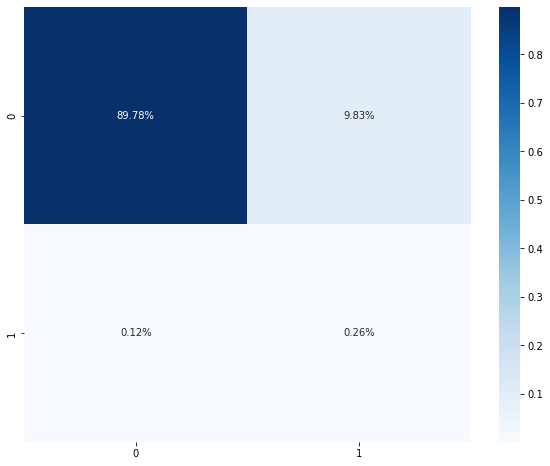

In [68]:
# Confusion matrix
cf=confusion_matrix(y_test,y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cf/np.sum(cf), annot=True, 
            fmt='.2%', cmap='Blues')

In [69]:

print("Classification report")
print(classification_report(y_test, y_pred))


Classification report
              precision    recall  f1-score   support

           0       1.00      0.90      0.95    553574
           1       0.03      0.69      0.05      2145

    accuracy                           0.90    555719
   macro avg       0.51      0.79      0.50    555719
weighted avg       0.99      0.90      0.94    555719



## Decision Tree Classifier

In [70]:
from sklearn.tree import DecisionTreeClassifier

In [71]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

<AxesSubplot:>

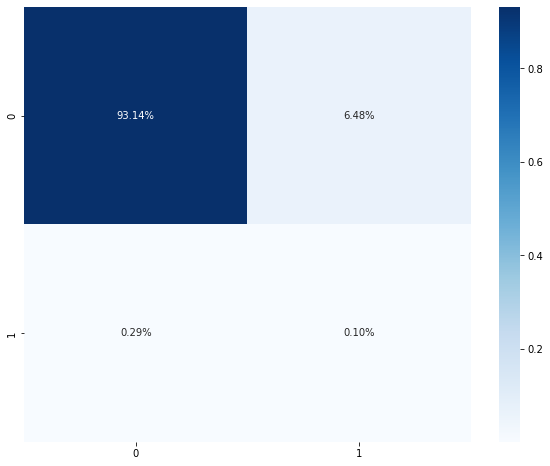

In [72]:

# Confusion matrix
cf=confusion_matrix(y_test,y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cf/np.sum(cf), annot=True, 
            fmt='.2%', cmap='Blues')

In [73]:

print("Classification report")
print(classification_report(y_test, y_pred))


Classification report
              precision    recall  f1-score   support

           0       1.00      0.93      0.96    553574
           1       0.02      0.26      0.03      2145

    accuracy                           0.93    555719
   macro avg       0.51      0.60      0.50    555719
weighted avg       0.99      0.93      0.96    555719



## LogisticRegression

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import  cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix

In [75]:
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)


LogisticRegression(random_state=42)

In [76]:
#Predict
y_pred = model.predict(X_test)


# Confusion matrix

In [77]:
# Confusion matrix
cf=confusion_matrix(y_test,y_pred)


In [78]:
X_test.shape

(555719, 14)

<AxesSubplot:>

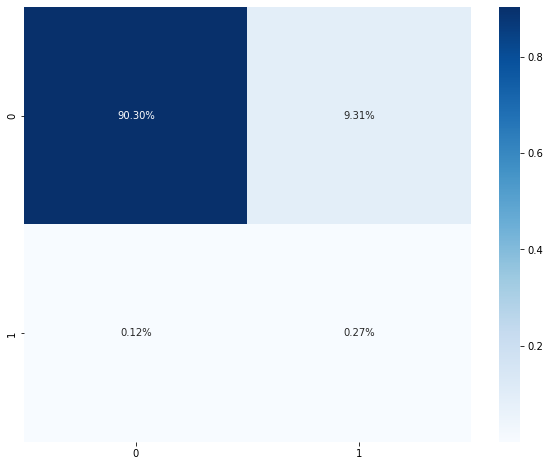

In [79]:

plt.figure(figsize=(10,8))
sns.heatmap(cf/np.sum(cf), annot=True, 
            fmt='.2%', cmap='Blues')

# Classification Report

In [80]:

print("Classification report")
print(classification_report(y_test, y_pred))


Classification report
              precision    recall  f1-score   support

           0       1.00      0.91      0.95    553574
           1       0.03      0.69      0.05      2145

    accuracy                           0.91    555719
   macro avg       0.51      0.80      0.50    555719
weighted avg       0.99      0.91      0.95    555719



# ROC_Curve

In [81]:
from sklearn import metrics

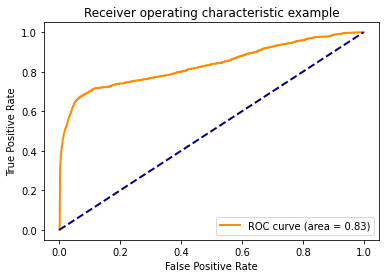

In [82]:
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [ ]:
#Dataset
#https://www.kaggle.com/datasets/kartik2112/fraud-detection

In [83]:
from numpy import loadtxt
from xgboost import XGBClassifier

# fit model no training data
clf = XGBClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:20:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<AxesSubplot:>

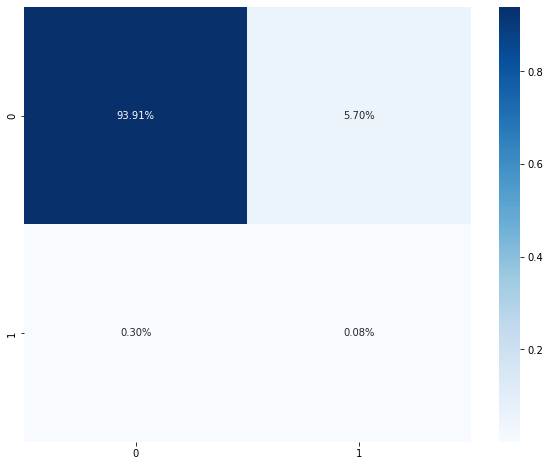

In [84]:

# Confusion matrix
cf=confusion_matrix(y_test,y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cf/np.sum(cf), annot=True, 
            fmt='.2%', cmap='Blues')

In [85]:

print("Classification report")
print(classification_report(y_test, y_pred))


Classification report
              precision    recall  f1-score   support

           0       1.00      0.94      0.97    553574
           1       0.01      0.21      0.03      2145

    accuracy                           0.94    555719
   macro avg       0.51      0.58      0.50    555719
weighted avg       0.99      0.94      0.97    555719

